<a href="https://colab.research.google.com/github/ejihoon6065/LSTM-Stock-Prices/blob/master/Hyundai_Stock_Yahoo_Finance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Activation
from pandas.io.parsers import read_csv

출처 : https://dk-kang.tistory.com/entry/%EC%BC%80%EB%9D%BC%EC%8A%A4-%EC%A3%BC%EA%B0%80-%EC%98%88%EC%B8%A1-%ED%94%84%EB%A1%9C%EA%B7%B8%EB%9E%A8-%EB%A7%8C%EB%93%A4%EA%B8%B0

# 파일 업로드

In [2]:
from google.colab import files
uploaded = files.upload()

Saving hyundai.csv to hyundai.csv


In [3]:
data = pd.read_csv('hyundai.csv')

In [4]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-09-11,28.00,28.00,28.00,28.00,28.00,0
1,2019-09-12,31.75,31.75,31.75,31.75,31.75,300
2,2019-09-13,31.75,31.75,31.75,31.75,31.75,0
3,2019-09-16,31.00,31.00,28.01,28.01,28.01,600
4,2019-09-17,28.01,28.01,28.01,28.01,28.01,200


# Null값 제거

- 제거를 안 하면, model 훈련 중, 에러를 유발합니다.

In [5]:
data = data.dropna(axis=0)

# 고가와 저가의 중간 값으로, mid price 구하기

- 고가와 저가를 변수로 이용해도 되지만, 예제에서는 중간값으로 접근

In [6]:
high_price = data['High'].values
low_price = data['Low'].values
mid_price = (high_price + low_price) / 2

### 50일씩 나누어 분리

- 데이터들을 첫날부터, 50일씩 끊어서 저장

예) [ [0~50일], [1~51일], [2~52일], [3~53일]....... ]

 

(why? 50일 치 데이터를 가지고 51일째 되는 날의 주가를 예측하기 위해서)

In [7]:
day_divided = 50
day_length = day_divided + 1
day_result = []
for i in range(len(mid_price) - day_length):
    day_result.append(mid_price[i: i + day_length])

### 분리된 데이터 확인

In [8]:
print("전체 데이터 Length : ", len(data))
print("나눈 데이터 Length : ", len(day_result))
print("나눈 데이터 0번째 : ")
print(day_result[0])
print(day_result[1])

전체 데이터 Length :  253
나눈 데이터 Length :  202
나눈 데이터 0번째 : 
[28.        31.75      31.75      29.505     28.01      28.01
 35.        35.        34.8999995 34.799999  34.799999  34.799999
 34.799999  30.        31.        30.705     30.        31.389999
 28.        28.        29.889999  29.889999  29.889999  29.889999
 29.889999  32.5       31.7       30.9       30.9       30.9
 34.400002  34.400002  31.4       31.95      32.        32.625
 29.8000005 31.4       31.4       31.4       31.4       31.4
 31.4       31.4       31.4       31.4       30.5       30.5
 30.5       31.35      31.35     ]
[31.75      31.75      29.505     28.01      28.01      35.
 35.        34.8999995 34.799999  34.799999  34.799999  34.799999
 30.        31.        30.705     30.        31.389999  28.
 28.        29.889999  29.889999  29.889999  29.889999  29.889999
 32.5       31.7       30.9       30.9       30.9       34.400002
 34.400002  31.4       31.95      32.        32.625     29.8000005
 31.4       31.4  

### 데이터 정규화(Normalized)

- 50일씩 나누었던 데이터들을 첫날 기준으로 정규화 진행

(첫날을 0으로 만들고, 나머지 날들은 그 비율로 나누어 정규화)

In [9]:
norm_result = []
for section in day_result:
    norm_section = [((float(p) / float(section[0])) - 1) for p in section]
    norm_result.append(norm_section)
day_result = np.array(norm_result)

### 분리된 데이터 정규화 결과 확인

In [10]:
print(day_result[0])

[0.         0.13392857 0.13392857 0.05375    0.00035714 0.00035714
 0.25       0.25       0.24642855 0.24285711 0.24285711 0.24285711
 0.24285711 0.07142857 0.10714286 0.09660714 0.07142857 0.12107139
 0.         0.         0.06749996 0.06749996 0.06749996 0.06749996
 0.06749996 0.16071429 0.13214286 0.10357143 0.10357143 0.10357143
 0.2285715  0.2285715  0.12142857 0.14107143 0.14285714 0.16517857
 0.06428573 0.12142857 0.12142857 0.12142857 0.12142857 0.12142857
 0.12142857 0.12142857 0.12142857 0.12142857 0.08928571 0.08928571
 0.08928571 0.11964286 0.11964286]


### 데이터셋 정의하기

- 전체 데이터중 학습 데이터(train_data)는 90%, 테스트 데이터(test_data)는 10% 로 나눔.

데이터가 많지 않아 학습 데이터 비중을 높임.(검증 데이터 사용 x)

In [11]:
train_data_rate = 0.9
boundary = round(day_result.shape[0] * train_data_rate)
train_data = day_result[:boundary, :]
test_data = day_result[boundary:, :]

### 데이터셋 분리하기

- 위에서 설정한 train data와 test data를 1차원으로 바꾸고, 각 데이터 0~49번째 가격정보는 x_data, 마지막 50번째는 y_data로 설정

(why? 각 데이터 0~49번째 가격 정보를 가지고, 50번째 가격 정보를 예측하기 위해)

In [12]:
x_train = train_data[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train_data[:, -1]

x_test = test_data[:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = test_data[:, -1]

### 데이터셋 확인하기



In [13]:
x_train.shape, x_test.shape

((182, 50, 1), (20, 50, 1))

### 모델 만들기

- LSTM, 순환 신경망(RNN) - 순서가 있는 데이터(소리, 언어, 날씨, 주가)처럼 시간의 변화에 함께 변화하면서 그 영향을 받을 때 사용.

(첫 번째 인자 : 메모리 셀의 개수)

(return_sequences=True : 모든 입력에 대해 출력을 내놓게 한다. return_sequences=False : time sep 마지막에서만 결과를 출력)

(imput_shape : 입력 값)

In [14]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(50, 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(1, activation='relu'))
model.compile(loss='mse', optimizer='sgd')

# 모델 확인하기

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________


# 모델 훈련하기

In [16]:
model.fit(x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs=15)

Epoch 1/15
19/19 [==============================] - 1s 34ms/step - loss: 0.0400 - val_loss: 0.1944
Epoch 2/15
19/19 [==============================] - 0s 6ms/step - loss: 0.0395 - val_loss: 0.1759
Epoch 3/15
19/19 [==============================] - 0s 6ms/step - loss: 0.0388 - val_loss: 0.1775
Epoch 4/15
19/19 [==============================] - 0s 6ms/step - loss: 0.0384 - val_loss: 0.1779
Epoch 5/15
19/19 [==============================] - 0s 6ms/step - loss: 0.0381 - val_loss: 0.1780
Epoch 6/15
19/19 [==============================] - 0s 6ms/step - loss: 0.0379 - val_loss: 0.1641
Epoch 7/15
19/19 [==============================] - 0s 6ms/step - loss: 0.0374 - val_loss: 0.1485
Epoch 8/15
19/19 [==============================] - 0s 6ms/step - loss: 0.0371 - val_loss: 0.1466
Epoch 9/15
19/19 [==============================] - 0s 6ms/step - loss: 0.0367 - val_loss: 0.1394
Epoch 10/15
19/19 [==============================] - 0s 6ms/step - loss: 0.0365 - val_loss: 0.1359
Epoch 11/15
19/19 

# 모델 예측하기

In [17]:
pred = model.predict(x_test)

# 예측값과 실제값 비교(with plot)

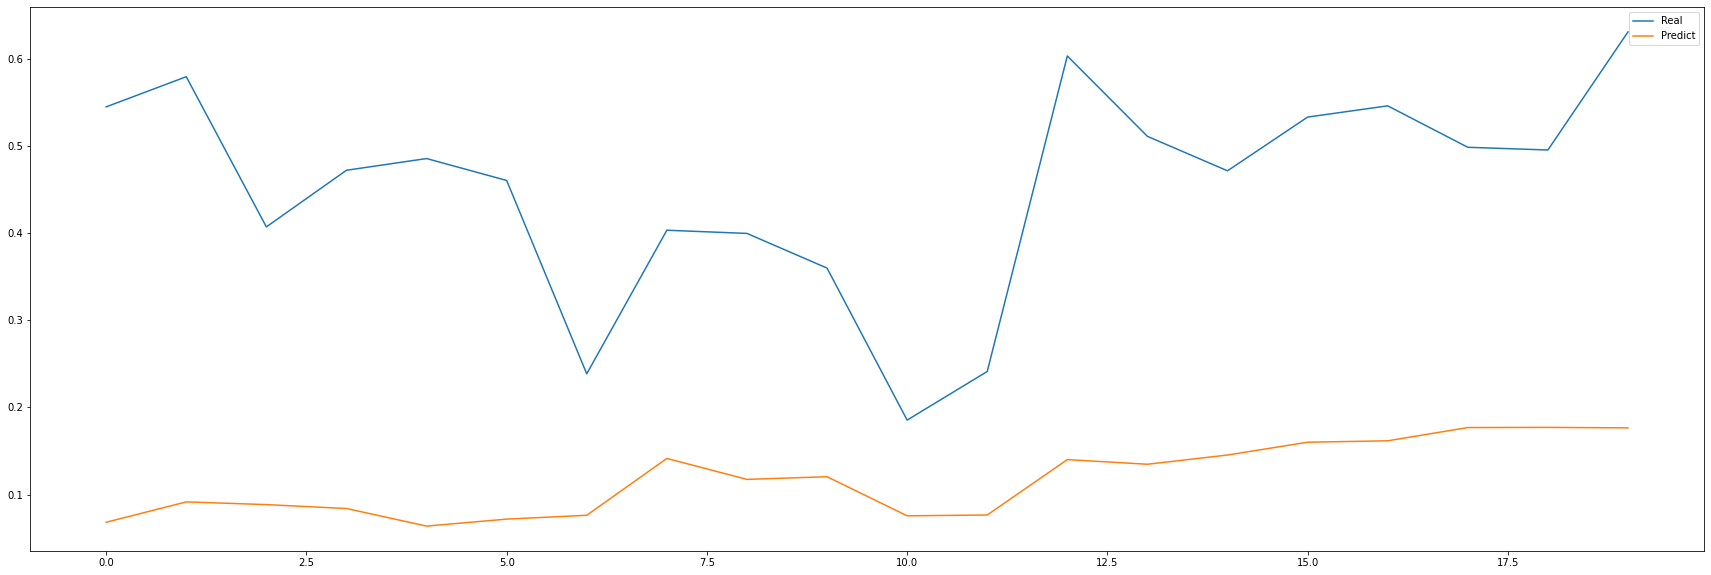

In [18]:
import matplotlib.pyplot as plt

plot_figure = plt.figure(figsize=(30, 10))
plot_rst = plot_figure.add_subplot(111)
plot_rst.plot(y_test, label='Real')
plot_rst.plot(pred, label='Predict')
plot_rst.legend()
plt.show()

얼추 비슷해 보이지만, 이것을 가지고 주가 예측을 하기에는 리스크가 크다.

아무래도 주가에 영향을 주는 변수는 많이 있기 때문이다. 주식에 관심 있으신 분들은 자신만의 전략을 만들고,

여러 정보를 변수화를 하여 모델을 만들어야 할 것이다.

 

물론 모든 게 참고 사항이며, 주식은 남들이 주는 고급 정보로 조심스럽게 접근하는 것이 최고인 듯싶다ㅜㅜ!